In [1]:
import os
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [5]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BULDING DATASET

In [8]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id, aspect_list, max_length=48):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(aspect_list)  # Total number of labels
        self.aspect_list = aspect_list
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        original_labels = torch.tensor([[self.label2id[label] for label in labels] for labels in self.gt_labels], dtype=torch.float32)
        encoded_labels = torch.tensor([[1 if label == 1 else 0 for label in labels] for labels in original_labels], dtype=torch.float32)
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * encoded_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx] 
        original_labels = torch.tensor([self.label2id[label] for label in self.gt_labels[idx]], dtype=torch.float32)
        encoded_labels = torch.tensor([1 if label == 1 else 0 for label in original_labels], dtype=torch.float32)

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 

        inputs_list = [text_inputs, encoded_labels, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_labels]
        return inputs_list

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, data, labels, aspects, indices, tokenizer, label2id, max_length):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = 2
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.aspects = aspects
        self.indices = indices
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.data[idx] 

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        if isinstance(self.gt_labels[idx], str):
            self.gt_labels[idx] = self.label2id[self.gt_labels[idx]]
        elif torch.is_tensor(self.gt_labels[idx]):
            self.gt_labels[idx] = int(self.gt_labels[idx].item())

        encoded_label = 1 if self.gt_labels[idx] == 2 else self.gt_labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 
        original_label = torch.tensor(self.gt_labels[idx], dtype=torch.long)
        aspect = self.aspects[idx]

        inputs_list = [text_inputs, one_hot_label, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_label, aspect, self.indices[idx]]
        return inputs_list

In [11]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [12]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    with torch.no_grad():
        for batch in train_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch[5][i])
                        train_labels.append(batch[6][i][j])
                        train_indices.append(batch[2][i])
            
        # Transform validation set
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch[5][i])
                        val_labels.append(batch[6][i][j])
                        val_indices.append(batch[2][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, tokenizer, label_mapping, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, tokenizer, label_mapping, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# DEFINE THE MODEL

In [13]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [14]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device, label_num):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = label_num
        self.cl_neg_mode = 2
        self.proto_size = 64
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, self.label_num * 512)
        self.fc1 = nn.Linear(512, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 512)
        self.agg = nn.Linear(self.label_num * 512, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None, reset_proto=False):
        if reset_proto:
            self.reset_proto()
        
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update positive instance counts
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.ins_neg_cnt += torch.sum(neg_mask)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
            
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        if self.cl_neg_mode == 2:
            dist_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[:self.label_num]])
            # print(dist_1[:3])
            dist_neg_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[self.label_num:]])
            dist_1 = torch.cat([dist_1, dist_neg_1], dim=1)  # Combine distances for positive and negative prototypes

        else:
            dist_1 = sub_rep_norm @ self.prototypes.T  

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [15]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=2):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=2):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [16]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [18]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [20]:
def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels, test_type):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 6 if test_type == 'aspect' else 2)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = torch.sigmoid(logits).data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

In [21]:
def train_total_sep2(aspect_datasets, dataloaders, trials, aspect_metrics, sentiment_metrics, metrics, current_train_size, filename, label_num=-1, seed=42, total_patience=3):
    set_seed(seed)
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)
    
    tasks = ['aspect', 'sentiment']
    sentiment_val_loader = None

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    for task in tasks:
        accelerator.print("--------------------------------------------------")
        if task == 'sentiment':
            accelerator.print("SENTIMENT ANALYSIS")
        else:
            accelerator.print("ASPECT DETECTION")
            
        accelerator.wait_for_everyone()
        best_score = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for first phase
        best_score2 = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for second phase
        second_phase = False  # Control flag for switching between training phases
        total_patience_cnt = 0
        models = {}

        # Initialize backbone model for task learning
        label_num = 10 if task == 'aspect' else 2
        models['backbone'] = IndoBERT_Backbone(label_num)
        optim_backbone = torch.optim.AdamW(models['backbone'].parameters(), lr=2e-5, weight_decay=0.01)

        # Initialize VAE module if specified (aligns with CoMAL's contrastive and auxiliary module)
        models['vae_module'] = MLP_VAE(768, device, label_num=label_num)
        optim_module = torch.optim.AdamW(models['vae_module'].parameters(), lr=2e-5, weight_decay=0.01)

        if task == 'sentiment':
            best_aspect_model = IndoBERT_Backbone(10)
            best_aspect_model.load_state_dict(torch.load(f"{filename}-aspect-p1-backbone-{trials+1}-{percentage}.pth"))
            train_loader, val_loader, _, _ = build_sentiment_dataset(
                device, aspect_datasets['train'], aspect_datasets['val'], best_aspect_model, tokenizer, max_length=sequence_length
            )
            sentiment_val_loader = val_loader
            
        else:
            train_loader = dataloaders['labeled']
            val_loader = dataloaders['test']

        accelerator.wait_for_everyone()
        models['backbone'], models['vae_module'], train_loader, val_loader = accelerator.prepare(
            models['backbone'], models['vae_module'], train_loader, val_loader
        )

        # Loop over epochs
        for epoch in range(1, epochs+1):
            if second_phase:
                models['backbone'].eval()  # Backbone frozen in second phase
            else:
                models['backbone'].train()
            models['vae_module'].train()

            # Iterate over labeled data for training
            total_loss = 0
            for data in train_loader:
                # Zero the gradients for all optimizers
                optim_backbone.zero_grad()
                optim_module.zero_grad()

                # Prepare inputs and labels for training
                labels, idx, loss_weight = [x.to(device) for x in data[1:4]]
                input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
                inputs_list = [input_ids, input_type_ids, input_mask, None]

                loss = 0

                # Forward pass through backbone model
                clf_out, encoder_cls = models['backbone'](inputs_list)

                # VAE training logic (aligns with CoMAL's multi-label decoupling and contrastive learning)
                loss2 = 0
                module_cls = encoder_cls.detach()  # Detach to prevent gradient flow to backbone

                # Forward pass through VAE module
                recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight, reset_proto=True)

                # Compute contrastive loss if enabled (aligns with CoMAL's use of contrastive learning)
                cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
                cl_labels_total = cl_labels.unsqueeze(-1)
                proj_total = latent_rep.view(-1, latent_rep.shape[-1])
                proj_total = F.normalize(proj_total, dim=-1)  # Normalize latent representation
                batch_size = clf_out.shape[0] * label_num
                mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)

                criterion_cl = SupConLoss()  # Supervised contrastive loss function
                cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
                loss2 += cl_loss  # Add contrastive loss

                # Compute reconstruction and classification loss
                criterion_mse = nn.MSELoss()
                recon_mse_loss = criterion_mse(recon_x, module_cls)
                criterion_bce = nn.BCEWithLogitsLoss()
                recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
                
                loss2 += recon_mse_loss + recon_bce_loss
                
                # Compute classification loss for the backbone (first phase)
                if not second_phase:
                    criterion = nn.BCEWithLogitsLoss()
                    clf_loss = criterion(clf_out, labels.float())
                    loss += clf_loss  # Add classification loss to total loss

                # Add VAE loss to total loss
                loss += loss2
                # Backpropagation step
                accelerator.backward(loss)
                
                total_loss += loss

                # Update weights based on current phase
                if second_phase:
                    optim_module.step()
                else:
                    optim_module.step()
                    optim_backbone.step()

            # Scheduler step for learning rate adjustment
            # if second_phase:
            #     accelerator.print('in second')
            
            result = {}
            outputs_clf = [[], [], [], [], []]
            outputs_dual = [[], [], [], [], []]
            match task:
                case 'aspect':
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                
                            clf_out, encoder_cls = models['backbone'](out)
                            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels, task)

                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=False)
                                outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels, task)

                    if second_phase:
                        outputs_dual = concat_test_result(outputs_dual)
                        preds = torch.tensor(outputs_dual[4], device=device)
                        labels = torch.tensor(outputs_dual[0], device=device)
                    else:
                        outputs_clf = concat_test_result(outputs_clf)
                        preds = torch.tensor(outputs_clf[4], device=device)
                        labels = torch.tensor(outputs_clf[0], device=device)

                    preds = accelerator.gather_for_metrics(preds)
                    labels = accelerator.gather_for_metrics(labels)
                        
                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': preds.cpu().numpy(), 'label_ids': labels.cpu().numpy()}),
                        None,
                        aspect_list,
                    )
                case 'sentiment':
                    sentiment_val_outputs = []
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                        
                            clf_out, encoder_cls = models['backbone'](out)
                            clf_out = torch.sigmoid(clf_out)
                        
                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=False)
                                recon_x_clf = torch.sigmoid(recon_x_clf)

                            for i in range(len(clf_out)):
                                val_output = {
                                    'label': data[1][i],
                                    'aspect': data[7][i],
                                    'ori_indices': data[2][i],
                                    'pred': np.argmax(clf_out[i].cpu().numpy() if not second_phase else recon_x_clf[i].cpu().numpy()),
                                }
                                sentiment_val_outputs.append(val_output)

                    sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
                    unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
                    sentiment_val_outputs = list(unique_val_outputs.values())

                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
                        [0, 1],
                        ['negative', 'positive']
                    )

            # if second_phase:
            #     if result["f1_micro"] >= best_score2['f1_micro']:
            #         total_patience_cnt = 0
            #         best_score2 = result
                    
            #         accelerator.wait_for_everyone()
            #         unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
            #         if accelerator.is_local_main_process:
            #             accelerator.save(unwrapped_vae.state_dict(), f"{filename}-{task}-p2-vae-{trials+1}-{percentage}.pth")
            #     else:
            #         total_patience_cnt += 1
            #         if total_patience_cnt >= total_patience:
            #             break
            # else:
            if result["f1_micro"] >= best_score['f1_micro']:
                best_score = result

                accelerator.wait_for_everyone()
                unwrapped_backbone = accelerator.unwrap_model(models['backbone'])
                unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
                
                if accelerator.is_local_main_process:
                    accelerator.save(unwrapped_backbone.state_dict(), f"{filename}-{task}-p1-backbone-{trials+1}-{percentage}.pth")
                    accelerator.save(unwrapped_vae.state_dict(), f"{filename}-{task}-p1-vae-{trials+1}-{percentage}.pth")
            # else:
            #     total_patience_cnt += 1
            #     if total_patience_cnt >= total_patience:
            #         total_patience_cnt = 0
            #         second_phase = True
                
            accelerator.print(f"EPOCH {epoch} | LOSS: {total_loss / len(dataloaders['labeled'])} | ACCURACY: {round(result['accuracy'], 4)} | F1 MACRO: {round(result['f1_macro'], 4)} | F1 MICRO: {round(result['f1_micro'], 4)}")

        if accelerator.is_local_main_process:
            if task == 'aspect':
                aspect_metrics[0].append(best_score['accuracy'])
                aspect_metrics[1].append(best_score['f1_micro'])
                aspect_metrics[2].append(best_score['f1_macro'])
            elif task == 'sentiment':
                sentiment_metrics[0].append(best_score['accuracy'])
                sentiment_metrics[1].append(best_score['f1_micro'])
                sentiment_metrics[2].append(best_score['f1_macro'])
        
        accelerator.print(f"{task}: ACCURACY {round(best_score['accuracy'], 4)} | F1 MACRO {round(best_score['f1_macro'], 4)} | F1 MICRO {round(best_score['f1_micro'], 4)}")
        accelerator.print(best_score['report'])

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []

    accelerator.wait_for_everyone()

    best_aspect_model = IndoBERT_Backbone(10)
    best_sentiment_model = IndoBERT_Backbone(2)

    best_aspect_model.load_state_dict(torch.load(f"{filename}-aspect-p1-backbone-{trials+1}-{percentage}.pth"))
    best_sentiment_model.load_state_dict(torch.load(f"{filename}-sentiment-p1-backbone-{trials+1}-{percentage}.pth"))

    best_aspect_model, best_sentiment_model, val_loader = accelerator.prepare(best_aspect_model, best_sentiment_model, dataloaders['test'])

    with torch.no_grad():
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_aspect_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()

            aspect_indices.append(accelerator.gather(batch[2]))
            aspect_labels.append(accelerator.gather(batch[6]))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_sentiment_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch[7][i],
                    'ori_indices': batch[8][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
            
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])

# QUERY STRATEGY

In [22]:
def query_samples(filename, dataset, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=2, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device

    models = {}
    tasks = ['aspect', 'sentiment']
    
    current_train_size = len(dataset.get_labeled_set())

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    for task in tasks:
        backbone = IndoBERT_Backbone(10 if task == 'aspect' else 2)
        vae = MLP_VAE(768, device, 10 if task == 'aspect' else 2)
        backbone.load_state_dict(torch.load(f"{filename}-{task}-p1-backbone-{trials+1}-{percentage}.pth"))
        models[f'{task}_backbone'] = backbone
        
        if os.path.exists(f'/kaggle/working/{filename}-{task}-p2-vae-{trials+1}.pth'):
            vae.load_state_dict(torch.load(f"{filename}-{task}-p2-vae-{trials+1}-{percentage}.pth"))
        else:
            vae.load_state_dict(torch.load(f"{filename}-{task}-p1-vae-{trials+1}-{percentage}.pth"))
        models[f'{task}_vae_module'] = vae

    # Set all models to evaluation mode to freeze parameters during sampling
    for model_name in models.keys():
        models[model_name].to(device)
        models[model_name].eval()

    # Initialize lists to store outputs used for sampling calculations
    aspect_outputs = {}
    sentiment_outputs = {}
    
    labeled_distances = []
    labeled_ground_truths = []
    
    labeled_aspects = []
    labeled_labels = []
    labeled_indices = []
    labeled_texts = []

    unlabeled_aspects = []
    unlabeled_labels = []
    unlabeled_ori_indices = []
    unlabeled_texts = []

    # DataLoader for labeled data subset, sampled randomly
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    start_time = time.time()

    # Process labeled data to extract features and distances for sampling criteria
    for batch in labeled_dataloader:
        text_inputs = batch[0]
        gt_label = batch[1]
        idx = batch[2]
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])

            for i in range(len(predictions)):
                indices = idx[i].item()
                for j in range(len(predictions[i])):
                    if int(predictions[i][j].round()) != 1:
                        labeled_aspects.append(aspect_list[j])
                        labeled_labels.append(gt_label[i][j])
                        labeled_texts.append(batch[5][i])
                        labeled_indices.append(indices)
                    
            _, sub_representation, _, vae_distance = models['aspect_vae_module'](encoded_cls)
            vae_distance = vae_distance.cpu().data
            labeled_distances.extend(vae_distance)

    # print(vae_distance[:10])

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        # Compute self-prototype distances based on CoMAL's contrastive learning mode
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # DataLoader for unlabeled data to compute sampling scores
        unlabeled_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            shuffle=False,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
        )
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_dataloader:
            text_inputs = batch[0]
            labels = batch[1]
            idx = batch[2]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    
                    if indices not in aspect_outputs.keys():
                        aspect_outputs[indices] = {}
                        
                    aspect_outputs[indices]['backbone_predictions'] = predictions[i]
                    aspect_outputs[indices]['loss_weight'] = loss_weight[i]
                    
                    # Collect non neutral aspect for sentiment analysis
                    for j in range(len(predictions[i])):
                        if int(torch.sigmoid(predictions[i][j]).round()) != 1:
                            unlabeled_aspects.append(aspect_list[j])
                            unlabeled_labels.append(labels[i][j])
                            unlabeled_texts.append(batch[5][i])
                            unlabeled_ori_indices.append(indices)
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['aspect_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    aspect_outputs[idx[i].item()]['backbone_distances'] = vae_distance[i].cpu().data

        # Convert lists to tensors for further computation
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        sample_weights = torch.stack([aspect_outputs[key]['loss_weight'] for key in aspect_outputs.keys()])
        distance_matrix = torch.stack([aspect_outputs[key]['backbone_distances'] for key in aspect_outputs.keys()])
    
        # Convert predictions to probability and adjust masks for scoring
        backbone_predictions = torch.stack([aspect_outputs[key]['backbone_predictions'] for key, val in aspect_outputs.items()])
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights)
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        
        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2

        # Create a mask for nonzero elements
        nonzero_mask = score_weight > 0
    
        # Sum only nonzero elements per row
        sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
        
        # Count nonzero elements per row
        count_nonzero = nonzero_mask.sum(dim=-1)
        
        # Avoid division by zero (optional, but recommended)
        count_nonzero = count_nonzero.clamp(min=1)
        
        # Compute mean
        score_weight = sum_nonzero / count_nonzero
        adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        z = 0
        for key in aspect_outputs.keys():
            aspect_outputs[key]['score'] = average_scores[z]
            z += 1

    # -------- SENTIMENT ANALYSIS ---------
    accelerator.wait_for_everyone()
    labeled_sentiment_dataset = SentimentAnalysisDataset(labeled_texts, labeled_labels, labeled_aspects, labeled_indices, tokenizer, label_mapping, max_length=sequence_length)
    unlabeled_sentiment_dataset = SentimentAnalysisDataset(unlabeled_texts, unlabeled_labels, unlabeled_aspects, unlabeled_ori_indices, tokenizer, label_mapping, max_length=sequence_length)
    
    labeled_loader = torch.utils.data.DataLoader(
        labeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    labeled_ground_truths = []
    labeled_distances = []
    for batch in labeled_loader:
        text_inputs = batch[0]
        gt_label = batch[1]
        gt_label /= 2
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                    
            _, sub_representation, _, vae_distance = models['sentiment_vae_module'](encoded_cls)
            labeled_distances.extend(vae_distance.cpu().data)

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_loader:
            text_inputs = batch[0]
            idx = batch[8]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                    
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    if indices not in sentiment_outputs.keys():
                        sentiment_outputs[indices] = {}
                        sentiment_outputs[idx[i].item()]['backbone_predictions'] = [predictions[i]]
                        sentiment_outputs[idx[i].item()]['loss_weight'] = [loss_weight[i]]
                    else:
                        sentiment_outputs[idx[i].item()]['backbone_predictions'].append(predictions[i])
                        sentiment_outputs[idx[i].item()]['loss_weight'].append(loss_weight[i])
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['sentiment_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    indices = idx[i].item()
                    if 'backbone_distances' not in sentiment_outputs[indices].keys():
                        sentiment_outputs[indices]['backbone_distances'] = [vae_distance[i].cpu().data]
                    else:
                        sentiment_outputs[indices]['backbone_distances'].append(vae_distance[i].cpu().data)

        # print(len(unlabeled_sentiment_dataset), length, len(sentiment_outputs))
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in sentiment_outputs.keys()])

        sample_weights = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['loss_weight']), dim=0).round() 
            for key in sentiment_outputs
        ])
        distance_matrix = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_distances']), dim=0)
            for key in sentiment_outputs
        ])
        backbone_predictions = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_predictions']), dim=0) 
            for key in sentiment_outputs
        ])
        
        # Convert predictions to probability and adjust masks for scoring
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights)
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        negative_distance_mask = ((probability_predictions < 0.5) * unlabeled_mask).float()

        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(2)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2
        score_weight_negative = negative_distance_mask * (negative_prototype_distances + 1) / 2
        score_weight = score_weight + score_weight_negative
        # Create a mask for nonzero elements
        nonzero_mask = score_weight > 0
    
        # Sum only nonzero elements per row
        sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
        
        # Count nonzero elements per row
        count_nonzero = nonzero_mask.sum(dim=-1)
        
        # Avoid division by zero (optional, but recommended)
        count_nonzero = count_nonzero.clamp(min=1)
        
        # Compute mean
        score_weight = sum_nonzero / count_nonzero
        adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_sentiment_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        z = 0
        for key in sentiment_outputs.keys():
            aspect_outputs[key]['score'] = (average_sentiment_scores[z] + aspect_outputs[key]['score']) / 2
            z += 1

        scores = np.array([output['score'] for output in aspect_outputs.values()])

        ranked_indices = np.argsort(scores)
        ranked_indices = ranked_indices[::-1]
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        
        # Select top samples for annotation
        threshold = np.percentile(scores, 90)
        items_greater_than_threshold = scores[scores >= threshold]
        num_of_candidates = min(math.ceil(0.1 * len(scores)), len(items_greater_than_threshold))
    
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
        else:
            selected_indices = ranked_indices[:nearest_cp - current_train_size]
            
            temp = dataset.get_labeled_set()
            temp.extend([unlabeled_indices[int(i)] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
    
            acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        for x in selected_indices:
            new_sample_data.append(unlabeled_indices[int(x)])
        new_sample_labels = None
        
        end_time = time.time()
        duration = end_time - start_time
    
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
        sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1

# PLOT RESULT

In [23]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [24]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_sample_data = manager.list()
    new_sample_labels = manager.list()
    filename = f'hoasa-comal-init-{init_size}'
    
    current_train_size = initial_train_size
    start_time = time.time()
    set_seed(seed)

    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    # Load label information and dataset
    label_num = 10
    _, _, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length)
    
    # Shuffle and initialize labeled and unlabeled sets
    indices = list(range(len(aspect_train_dataset)))
    random.shuffle(indices)
    labeled_set = indices[:initial_train_size]  # Random initial labeled set
    unlabeled_set = [x for x in indices if x not in labeled_set]  # Define the unlabeled set
    
    # Update dataset with initial labeled set
    aspect_train_dataset.update_data(labeled_set, init_time=True)
    
    # Prepare data loaders for labeled and test sets
    labeled_loader = DataLoader(
        aspect_train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )
    test_loader = DataLoader(
        aspect_val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )

    models = {}

    while current_train_size < checkpoints[len(checkpoints) - 1]:
        dataloaders = {
            'labeled': labeled_loader,
            'test': test_loader
        }
        aspect_datasets = {
            'train': aspect_train_dataset,
            'val': aspect_val_dataset
        }
    
        # Train model
        train_args = (
            aspect_datasets,
            dataloaders, 
            i, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            current_train_size, 
            filename,
            label_num,
            seed
        )
        notebook_launcher(train_total_sep2, train_args, num_processes=2)
        
        query_set = list(set(unlabeled_set))
        # random.shuffle(query_set)
    
        # Query samples for next cycle, using appropriate selection strategy
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
        sampling_args = (
            filename,
            aspect_train_dataset, 
            labeled_set,
            query_set, 
            label_num,
            i,
            sampling_dur,
            new_sample_data,
            new_sample_labels,
            aspect_train_dataset.get_label_Cardinality()
        )
        notebook_launcher(query_samples, sampling_args, num_processes=2)
        new_sample_data = list(new_sample_data)
        new_sample_labels = list(new_sample_labels)

        # print(len(new_sample_data))
        aspect_train_dataset.update_data(new_sample_data, None)
        labeled_set = aspect_train_dataset.get_labeled_set()
        unlabeled_set = [x for x in indices if x not in labeled_set]
    
        # Refresh data loader with new labeled set
        labeled_loader = DataLoader(
            aspect_train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(labeled_set)))
        )
        
        # Update current train size
        current_train_size = len(labeled_set)
        print("New train size:", current_train_size)
    
    # DataLoader dictionary to be used for training and testing
    dataloaders = {
        'labeled': labeled_loader,
        'test': test_loader
    }
    
    # Train last iteration
    train_args = (
        aspect_datasets,
        dataloaders, 
        i, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        current_train_size, 
        filename,
        label_num,
        seed
    )
    notebook_launcher(train_total_sep2, train_args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
        
    # Log results
    end_time = time.time()
    duration = end_time - start_time

    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")

    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.378692865371704 | ACCURACY: 0.7726 | F1 MACRO: 0.8418 | F1 MICRO: 0.8656
EPOCH 2 | LOSS: 2.3396739959716797 | ACCURACY: 0.7958 | F1 MACRO: 0.8679 | F1 MICRO: 0.8829
EPOCH 3 | LOSS: 2.185382604598999 | ACCURACY: 0.7981 | F1 MACRO: 0.8738 | F1 MICRO: 0.8853
EPOCH 4 | LOSS: 2.1713178157806396 | ACCURACY: 0.7991 | F1 MACRO: 0.8762 | F1 MICRO: 0.8863
EPOCH 5 | LOSS: 2.0668272972106934 | ACCURACY: 0.8019 | F1 MACRO: 0.878 | F1 MICRO: 0.8879
EPOCH 6 | LOSS: 2.117741823196411 | ACCURACY: 0.8002 | F1 MACRO: 0.875 | F1 MICRO: 0.8866
EPOCH 7 | LOSS: 2.0270817279815674 | ACCURACY: 0.8016 | F1 MACRO: 0.8744 | F1 MICRO: 0.887
EPOCH 8 | LOSS: 2.117784023284912 | ACCURACY: 0.8017 | F1 MACRO: 0.8725 | F1 MICRO: 0.8868
EPOCH 9 | LOSS: 2.121457099914551 | ACCURACY: 0.803 | F1 MACRO: 0.8736 | F1 MICRO: 0.8875
EPOCH 10 | LOSS: 2.1243841648

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 28: Accuracy: 0.7974, F1 Micro: 0.7974, F1 Macro: 0.3169
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        97
     neutral       0.80      1.00      0.89       459
    positive       0.00      0.00      0.00        15

    accuracy                           0.80       571
   macro avg       0.27      0.33      0.30       571
weighted avg       0.65      0.80      0.72       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        86
     neutral       0.83      0.99      0.90       475
    positive       0.00      0.00      0.00        10

    accuracy                           0.82       571
   macro avg       0.28      0.33      0.30       571
weighted avg       0.69      0.82      0.75       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 254: Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.6539
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.92      0.89      0.91        97
     neutral       0.97      0.98      0.98       459
    positive       0.77      0.67      0.71        15

    accuracy                           0.96       571
   macro avg       0.89      0.85      0.87       571
weighted avg       0.96      0.96      0.96       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.92      0.64      0.75        86
     neutral       0.93      0.98      0.95       475
    positive       0.20      0.20      0.20        10

    accuracy                           0.91       571
   macro avg       0.68      0.61      0.64       571
weighted avg       0.91      0.91      0.91       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9049264192581177
Samples above threshold: 183
Acquired samples: 183
Sampling duration: 33.32893347740173 seconds
New train size: 640
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0955331325531006 | ACCURACY: 0.8071 | F1 MACRO: 0.8862 | F1 MICRO: 0.8919
EPOCH 2 | LOSS: 1.8836030960083008 | ACCURACY: 0.8415 | F1 MACRO: 0.9039 | F1 MICRO: 0.9092
EPOCH 3 | LOSS: 1.8545979261398315 | ACCURACY: 0.8986 | F1 MACRO: 0.934 | F1 MICRO: 0.939
EPOCH 4 | LOSS: 1.8114174604415894 | ACCURACY: 0.9201 | F1 MACRO: 0.9473 | F1 MICRO: 0.9515
EPOCH 5 | LOSS: 1.721011757850647 | ACCURACY: 0.9259 | F1 MACRO: 0.9515 | F1 MICRO: 0.9547
EPOCH 6 | LOSS: 1.6626545190811157 | ACCURACY: 0.9319 | F1 MACRO: 0.9554 | F1 MICRO: 0.9585
EPOCH 7 | LOSS: 1.6210764646530151 | ACCURACY: 0.9372 | F1 MACRO: 0.9584 | F1 MICRO: 0.9614
EPOCH 8 | LOSS: 1.6033216714859009 | ACCURACY: 0.9413 | F1 MACRO

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 12.629193305969238 | ACCURACY: 0.8394 | F1 MACRO: 0.8047 | F1 MICRO: 0.8394
EPOCH 2 | LOSS: 10.72243595123291 | ACCURACY: 0.869 | F1 MACRO: 0.8308 | F1 MICRO: 0.869
EPOCH 3 | LOSS: 10.219707489013672 | ACCURACY: 0.8867 | F1 MACRO: 0.8519 | F1 MICRO: 0.8867
EPOCH 4 | LOSS: 9.68387508392334 | ACCURACY: 0.8897 | F1 MACRO: 0.857 | F1 MICRO: 0.8897
EPOCH 5 | LOSS: 9.35802173614502 | ACCURACY: 0.8936 | F1 MACRO: 0.8638 | F1 MICRO: 0.8936
EPOCH 6 | LOSS: 9.017402648925781 | ACCURACY: 0.8936 | F1 MACRO: 0.8688 | F1 MICRO: 0.8936
EPOCH 7 | LOSS: 8.674498558044434 | ACCURACY: 0.9054 | F1 MACRO: 0.8808 | F1 MICRO: 0.9054
EPOCH 8 | LOSS: 8.508564949035645 | ACCURACY: 0.8916 | F1 MACRO: 0.8653 | F1 MICRO: 0.8916
EPOCH 9 | LOSS: 8.455972671508789 | ACCURACY: 0.8936 | F1 MACRO: 0.8665 | F1 MICRO: 0.8936
EPOCH 10 | LOSS: 7.924810886383057 | ACCURACY: 0.8857 | F1 MACRO: 0.857 | F1 MICRO: 0.8857
sentiment: ACCURACY 0.9054 | F1 MACRO 0.8808 | F1 MICRO 0.9054
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9150987386703493
Samples above threshold: 133
Acquired samples: 133
Sampling duration: 47.634828329086304 seconds
New train size: 1086
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0313727855682373 | ACCURACY: 0.8365 | F1 MACRO: 0.8989 | F1 MICRO: 0.9057
EPOCH 2 | LOSS: 1.8489333391189575 | ACCURACY: 0.9026 | F1 MACRO: 0.9377 | F1 MICRO: 0.9416
EPOCH 3 | LOSS: 1.7510420083999634 | ACCURACY: 0.9269 | F1 MACRO: 0.9497 | F1 MICRO: 0.9552
EPOCH 4 | LOSS: 1.6644405126571655 | ACCURACY: 0.9406 | F1 MACRO: 0.9607 | F1 MICRO: 0.9636
EPOCH 5 | LOSS: 1.5998525619506836 | ACCURACY: 0.947 | F1 MACRO: 0.9643 | F1 MICRO: 0.9674
EPOCH 6 | LOSS: 1.5559942722320557 | ACCURACY: 0.9464 | F1 MACRO: 0.9637 | F1 MICRO: 0.9669
EPOCH 7 | LOSS: 1.5019499063491821 | ACCURACY: 0.9536 | F1 MACRO: 0.9676 | F1 MICRO: 0.9712
EPOCH 8 | LOSS: 1.45596182346344 | ACCURACY: 0.9505 | F1 MAC

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9979537725448608 | ACCURACY: 0.8694 | F1 MACRO: 0.9188 | F1 MICRO: 0.9232
EPOCH 2 | LOSS: 1.8056390285491943 | ACCURACY: 0.9271 | F1 MACRO: 0.9523 | F1 MICRO: 0.9558
EPOCH 3 | LOSS: 1.6844757795333862 | ACCURACY: 0.9406 | F1 MACRO: 0.9607 | F1 MICRO: 0.9637
EPOCH 4 | LOSS: 1.6088085174560547 | ACCURACY: 0.9477 | F1 MACRO: 0.9642 | F1 MICRO: 0.9678
EPOCH 5 | LOSS: 1.5489906072616577 | ACCURACY: 0.9517 | F1 MACRO: 0.9675 | F1 MICRO: 0.9703
EPOCH 6 | LOSS: 1.4952807426452637 | ACCURACY: 0.9536 | F1 MACRO: 0.9683 | F1 MICRO: 0.9713
EPOCH 7 | LOSS: 1.4460573196411133 | ACCURACY: 0.95 | F1 MACRO: 0.9662 | F1 MICRO: 0.9691
EPOCH 8 | LOSS: 1.4090982675552368 | ACCURACY: 0.9545 | F1 MACRO: 0.9689 | F1 MICRO: 0.9719
EPOCH 9 | LOSS: 1.3707787990570068 | ACCURACY: 0.9507 | F1 MACRO: 0.9662 | F1 MICRO: 0.9694
EPOCH 10 | LOSS: 1.3437881469726562 | ACCURACY: 0.954 | F1 MACRO: 0.9686 | F1 MICRO: 0.9715
aspect: ACCURACY 0.9545 | F1 MACRO 0.9689 | F1 MICRO 0.9719
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.492273807525635 | ACCURACY: 0.8534 | F1 MACRO: 0.8262 | F1 MICRO: 0.8534
EPOCH 2 | LOSS: 4.512791156768799 | ACCURACY: 0.8796 | F1 MACRO: 0.8467 | F1 MICRO: 0.8796
EPOCH 3 | LOSS: 4.2193803787231445 | ACCURACY: 0.8926 | F1 MACRO: 0.8627 | F1 MICRO: 0.8926
EPOCH 4 | LOSS: 4.071601867675781 | ACCURACY: 0.8777 | F1 MACRO: 0.8368 | F1 MICRO: 0.8777
EPOCH 5 | LOSS: 3.966127872467041 | ACCURACY: 0.8814 | F1 MACRO: 0.843 | F1 MICRO: 0.8814
EPOCH 6 | LOSS: 3.8550782203674316 | ACCURACY: 0.9038 | F1 MACRO: 0.8778 | F1 MICRO: 0.9038
EPOCH 7 | LOSS: 3.744170904159546 | ACCURACY: 0.8889 | F1 MACRO: 0.8638 | F1 MICRO: 0.8889
EPOCH 8 | LOSS: 3.605771780014038 | ACCURACY: 0.8992 | F1 MACRO: 0.8709 | F1 MICRO: 0.8992
EPOCH 9 | LOSS: 3.566561222076416 | ACCURACY: 0.9029 | F1 MACRO: 0.8781 | F1 MICRO: 0.9029
EPOCH 10 | LOSS: 3.455493927001953 | ACCURACY: 0.8982 | F1 MACRO: 0.8678 | F1 MICRO: 0.8982
sentiment: ACCURACY 0.9038 | F1 MACRO 0.8778 | F1 MICRO 0.9038
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.879940414428711
Samples above threshold: 77
Acquired samples: 77
Sampling duration: 62.80970788002014 seconds
New train size: 1590
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9625322818756104 | ACCURACY: 0.8797 | F1 MACRO: 0.9241 | F1 MICRO: 0.929
EPOCH 2 | LOSS: 1.7938300371170044 | ACCURACY: 0.933 | F1 MACRO: 0.9564 | F1 MICRO: 0.9592
EPOCH 3 | LOSS: 1.648864507675171 | ACCURACY: 0.9441 | F1 MACRO: 0.961 | F1 MICRO: 0.9654
EPOCH 4 | LOSS: 1.5970029830932617 | ACCURACY: 0.9458 | F1 MACRO: 0.9639 | F1 MICRO: 0.9667
EPOCH 5 | LOSS: 1.514453649520874 | ACCURACY: 0.9516 | F1 MACRO: 0.9668 | F1 MICRO: 0.97
EPOCH 6 | LOSS: 1.4495699405670166 | ACCURACY: 0.9531 | F1 MACRO: 0.9683 | F1 MICRO: 0.9711
EPOCH 7 | LOSS: 1.4229296445846558 | ACCURACY: 0.9535 | F1 MACRO: 0.9682 | F1 MICRO: 0.9711
EPOCH 8 | LOSS: 1.3744868040084839 | ACCURACY: 0.9538 | F1 MACRO: 0.96

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.351658344268799 | ACCURACY: 0.8553 | F1 MACRO: 0.8149 | F1 MICRO: 0.8553
EPOCH 2 | LOSS: 4.38139009475708 | ACCURACY: 0.8764 | F1 MACRO: 0.8421 | F1 MICRO: 0.8764
EPOCH 3 | LOSS: 4.128000259399414 | ACCURACY: 0.8874 | F1 MACRO: 0.8538 | F1 MICRO: 0.8874
EPOCH 4 | LOSS: 4.020622730255127 | ACCURACY: 0.8965 | F1 MACRO: 0.8666 | F1 MICRO: 0.8965
EPOCH 5 | LOSS: 3.947331428527832 | ACCURACY: 0.8956 | F1 MACRO: 0.8653 | F1 MICRO: 0.8956
EPOCH 6 | LOSS: 3.642315626144409 | ACCURACY: 0.8892 | F1 MACRO: 0.8584 | F1 MICRO: 0.8892
EPOCH 7 | LOSS: 3.518970012664795 | ACCURACY: 0.8947 | F1 MACRO: 0.8637 | F1 MICRO: 0.8947
EPOCH 8 | LOSS: 3.474837303161621 | ACCURACY: 0.8828 | F1 MACRO: 0.8514 | F1 MICRO: 0.8828
EPOCH 9 | LOSS: 3.3983113765716553 | ACCURACY: 0.8855 | F1 MACRO: 0.8501 | F1 MICRO: 0.8855
EPOCH 10 | LOSS: 3.296576499938965 | ACCURACY: 0.8984 | F1 MACRO: 0.8672 | F1 MICRO: 0.8984
sentiment: ACCURACY 0.8984 | F1 MACRO 0.8672 | F1 MICRO 0.8984
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1590: Accuracy: 0.9525, F1 Micro: 0.9525, F1 Macro: 0.8621
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.94      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87        86
     neutral       0.98      0.99      0.98       475
    positive       0.57      0.40      0.47        10

    accuracy                           0.96       571
   macro avg       0.82      0.75      0.78       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.8436378479003905
Samples above threshold: 70
Acquired samples: 70
Sampling duration: 65.68502044677734 seconds
New train size: 1660
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9651224613189697 | ACCURACY: 0.8859 | F1 MACRO: 0.9284 | F1 MICRO: 0.9325
EPOCH 2 | LOSS: 1.7813935279846191 | ACCURACY: 0.9361 | F1 MACRO: 0.9583 | F1 MICRO: 0.961
EPOCH 3 | LOSS: 1.6449772119522095 | ACCURACY: 0.9417 | F1 MACRO: 0.9613 | F1 MICRO: 0.9644
EPOCH 4 | LOSS: 1.5824370384216309 | ACCURACY: 0.9524 | F1 MACRO: 0.9679 | F1 MICRO: 0.9706
EPOCH 5 | LOSS: 1.5081461668014526 | ACCURACY: 0.9545 | F1 MACRO: 0.9689 | F1 MICRO: 0.9718
EPOCH 6 | LOSS: 1.4544676542282104 | ACCURACY: 0.9543 | F1 MACRO: 0.9691 | F1 MICRO: 0.9717
EPOCH 7 | LOSS: 1.402244210243225 | ACCURACY: 0.9556 | F1 MACRO: 0.9696 | F1 MICRO: 0.9725
EPOCH 8 | LOSS: 1.377156376838684 | ACCURACY: 0.9547 | F1 MACRO:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.999422550201416 | ACCURACY: 0.8291 | F1 MACRO: 0.756 | F1 MICRO: 0.8291
EPOCH 2 | LOSS: 4.167036533355713 | ACCURACY: 0.8682 | F1 MACRO: 0.8404 | F1 MICRO: 0.8682
EPOCH 3 | LOSS: 3.9629874229431152 | ACCURACY: 0.8827 | F1 MACRO: 0.8505 | F1 MICRO: 0.8827
EPOCH 4 | LOSS: 3.7585270404815674 | ACCURACY: 0.8864 | F1 MACRO: 0.8572 | F1 MICRO: 0.8864
EPOCH 5 | LOSS: 3.5731942653656006 | ACCURACY: 0.8845 | F1 MACRO: 0.8537 | F1 MICRO: 0.8845
EPOCH 6 | LOSS: 3.478433609008789 | ACCURACY: 0.8818 | F1 MACRO: 0.8532 | F1 MICRO: 0.8818
EPOCH 7 | LOSS: 3.3813745975494385 | ACCURACY: 0.8645 | F1 MACRO: 0.8369 | F1 MICRO: 0.8645
EPOCH 8 | LOSS: 3.365534782409668 | ACCURACY: 0.8955 | F1 MACRO: 0.8673 | F1 MICRO: 0.8955
EPOCH 9 | LOSS: 3.209003448486328 | ACCURACY: 0.8909 | F1 MACRO: 0.8616 | F1 MICRO: 0.8909
EPOCH 10 | LOSS: 3.099888801574707 | ACCURACY: 0.8909 | F1 MACRO: 0.8625 | F1 MICRO: 0.8909
sentiment: ACCURACY 0.8955 | F1 MACRO 0.8673 | F1 MICRO 0.8955
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: nan | ACCURACY: 0.8522 | F1 MACRO: 0.7902 | F1 MICRO: 0.8522
EPOCH 2 | LOSS: nan | ACCURACY: 0.8896 | F1 MACRO: 0.8531 | F1 MICRO: 0.8896
EPOCH 3 | LOSS: nan | ACCURACY: 0.8924 | F1 MACRO: 0.8537 | F1 MICRO: 0.8924
EPOCH 4 | LOSS: nan | ACCURACY: 0.8915 | F1 MACRO: 0.8534 | F1 MICRO: 0.8915
EPOCH 5 | LOSS: nan | ACCURACY: 0.8887 | F1 MACRO: 0.8562 | F1 MICRO: 0.8887
EPOCH 6 | LOSS: nan | ACCURACY: 0.898 | F1 MACRO: 0.8631 | F1 MICRO: 0.898
EPOCH 7 | LOSS: nan | ACCURACY: 0.8934 | F1 MACRO: 0.8608 | F1 MICRO: 0.8934
EPOCH 8 | LOSS: nan | ACCURACY: 0.9036 | F1 MACRO: 0.8744 | F1 MICRO: 0.9036
EPOCH 9 | LOSS: nan | ACCURACY: 0.9036 | F1 MACRO: 0.875 | F1 MICRO: 0.9036
EPOCH 10 | LOSS: nan | ACCURACY: 0.8971 | F1 MACRO: 0.865 | F1 MICRO: 0.8971
sentiment: ACCURACY 0.9036 | F1 MACRO 0.875 | F1 MICRO 0.9036
              precision    recall  f1-score   support

    negative       0.90      0.97      0.93       764
    positive       0.90      0.74      0.82       305

    acc

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1822: Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.8307
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.98      0.99      0.99       459
    positive       0.87      0.87      0.87        15

    accuracy                           0.98       571
   macro avg       0.94      0.93      0.93       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.85      0.88        86
     neutral       0.98      1.00      0.99       475
    positive       0.50      0.40      0.44        10

    accuracy                           0.96       571
   macro avg       0.80      0.75      0.77       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: nan
Samples above threshold: 0
Acquired samples: 50
Sampling duration: 70.62840580940247 seconds
New train size: 1872
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9799374341964722 | ACCURACY: 0.8944 | F1 MACRO: 0.9316 | F1 MICRO: 0.9369
EPOCH 2 | LOSS: 1.7837108373641968 | ACCURACY: 0.9384 | F1 MACRO: 0.9598 | F1 MICRO: 0.9624
EPOCH 3 | LOSS: 1.6543161869049072 | ACCURACY: 0.9491 | F1 MACRO: 0.9654 | F1 MICRO: 0.9686
EPOCH 4 | LOSS: 1.5754210948944092 | ACCURACY: 0.9483 | F1 MACRO: 0.9653 | F1 MICRO: 0.9682
EPOCH 5 | LOSS: 1.5078799724578857 | ACCURACY: 0.9542 | F1 MACRO: 0.9689 | F1 MICRO: 0.9716
EPOCH 6 | LOSS: 1.457198143005371 | ACCURACY: 0.9533 | F1 MACRO: 0.9682 | F1 MICRO: 0.9711
EPOCH 7 | LOSS: 1.4043049812316895 | ACCURACY: 0.9578 | F1 MACRO: 0.9714 | F1 MICRO: 0.9739
EPOCH 8 | LOSS: 1.3730418682098389 | ACCURACY: 0.9559 | F1 MACRO: 0.9701 | F1 MICRO: 0.9727
EPOCH 9 | LOSS: 1.3438093662261963 | ACCURACY: 0.9578 | F1 MACRO: 0.9714 | F1 MICRO: 0.9738
EPOCH 10 | LOSS: 1.3157864809036255 | ACCURACY: 0.9583 | F1 MACRO: 0.9718 | F1 MICRO: 0.9742
aspect: ACCURACY 0.9583 | F1 MACRO 0.9718 | F1 MICRO 0.9742
              precis

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.942805290222168
Samples above threshold: 19
Acquired samples: 50
Sampling duration: 77.24714827537537 seconds
New train size: 2147
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9666801691055298 | ACCURACY: 0.9083 | F1 MACRO: 0.9413 | F1 MICRO: 0.945
EPOCH 2 | LOSS: 1.7316291332244873 | ACCURACY: 0.9382 | F1 MACRO: 0.9594 | F1 MICRO: 0.9623
EPOCH 3 | LOSS: 1.6082725524902344 | ACCURACY: 0.9488 | F1 MACRO: 0.9653 | F1 MICRO: 0.9685
EPOCH 4 | LOSS: 1.5245592594146729 | ACCURACY: 0.9564 | F1 MACRO: 0.9696 | F1 MICRO: 0.9729
EPOCH 5 | LOSS: 1.4727602005004883 | ACCURACY: 0.9559 | F1 MACRO: 0.9696 | F1 MICRO: 0.9726
EPOCH 6 | LOSS: 1.423793077468872 | ACCURACY: 0.9587 | F1 MACRO: 0.9719 | F1 MICRO: 0.9743
EPOCH 7 | LOSS: 1.3797684907913208 | ACCURACY: 0.9595 | F1 MACRO: 0.9723 | F1 MICRO: 0.9749
EPOCH 8 | LOSS: 1.3602675199508667 | ACCURACY: 0.9549 | F1 MACRO:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.875567674636841
Samples above threshold: 14
Acquired samples: 50
Sampling duration: 78.25954794883728 seconds
New train size: 2197
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9378910064697266 | ACCURACY: 0.9109 | F1 MACRO: 0.9422 | F1 MICRO: 0.9462
EPOCH 2 | LOSS: 1.7106351852416992 | ACCURACY: 0.9458 | F1 MACRO: 0.9643 | F1 MICRO: 0.9666
EPOCH 3 | LOSS: 1.6004796028137207 | ACCURACY: 0.9505 | F1 MACRO: 0.967 | F1 MICRO: 0.9695
EPOCH 4 | LOSS: 1.5252164602279663 | ACCURACY: 0.9568 | F1 MACRO: 0.9706 | F1 MICRO: 0.9733
EPOCH 5 | LOSS: 1.462223768234253 | ACCURACY: 0.955 | F1 MACRO: 0.9695 | F1 MICRO: 0.9722
EPOCH 6 | LOSS: 1.414148211479187 | ACCURACY: 0.9575 | F1 MACRO: 0.9708 | F1 MICRO: 0.9736
EPOCH 7 | LOSS: 1.3762238025665283 | ACCURACY: 0.9571 | F1 MACRO: 0.9703 | F1 MICRO: 0.9734
EPOCH 8 | LOSS: 1.346497654914856 | ACCURACY: 0.9564 | F1 MACRO: 0.

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2197: Accuracy: 0.9566, F1 Micro: 0.9566, F1 Macro: 0.8668
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.87      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.79      0.82       571
weighted avg       0.96      0.97      0.97       571

Aspect bau report:
     

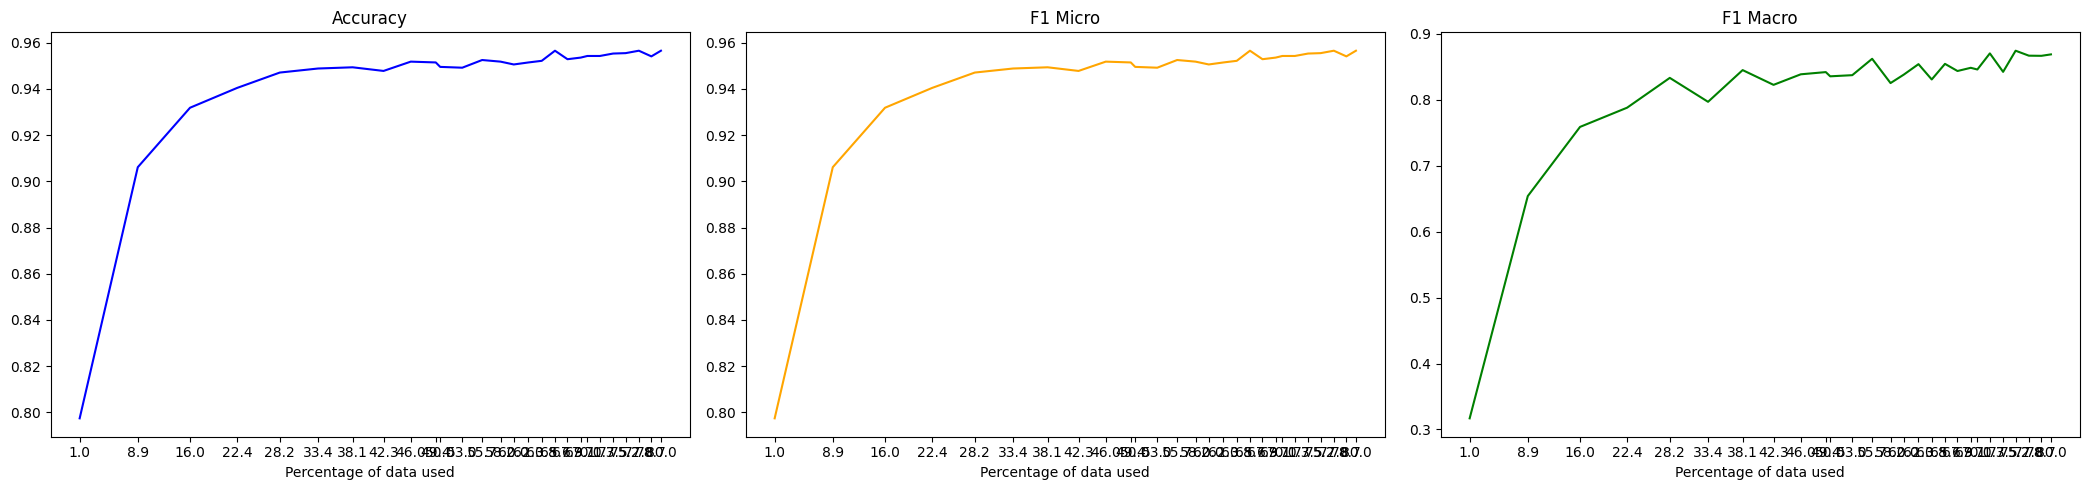

In [25]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.238168716430664 | ACCURACY: 0.8052 | F1 MACRO: 0.8791 | F1 MICRO: 0.8895
EPOCH 2 | LOSS: 2.0285024642944336 | ACCURACY: 0.8141 | F1 MACRO: 0.8883 | F1 MICRO: 0.8947
EPOCH 3 | LOSS: 1.959983229637146 | ACCURACY: 0.822 | F1 MACRO: 0.8906 | F1 MICRO: 0.8983
EPOCH 4 | LOSS: 1.8939454555511475 | ACCURACY: 0.837 | F1 MACRO: 0.8992 | F1 MICRO: 0.9058
EPOCH 5 | LOSS: 1.8917590379714966 | ACCURACY: 0.8634 | F1 MACRO: 0.9149 | F1 MICRO: 0.92
EPOCH 6 | LOSS: 1.8909310102462769 | ACCURACY: 0.8839 | F1 MACRO: 0.9253 | F1 MICRO: 0.9308
EPOCH 7 | LOSS: 1.8540880680084229 | ACCURACY: 0.897 | F1 MACRO: 0.9325 | F1 MICRO: 0.938
EPOCH 8 | LOSS: 1.8039528131484985 | ACCURACY: 0.905 | F1 MACRO: 0.9374 | F1 MICRO: 0.9424
EPOCH 9 | LOSS: 1.7533726692199707 | ACCURACY: 0.916 | F1 MACRO: 0.9434 | F1 MICRO: 0.9489
EPOCH 10 | LOSS: 1.712166428565979 | ACCURACY: 0.9108 | F1 MACRO: 0.9399 | F1 MICRO: 0.9458
aspect: ACCURACY 0.916 | F1 MACRO 0.9434 | F1 MICRO 0.9489
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 27.400053024291992 | ACCURACY: 0.8271 | F1 MACRO: 0.7906 | F1 MICRO: 0.8271
EPOCH 2 | LOSS: 23.721487045288086 | ACCURACY: 0.8399 | F1 MACRO: 0.8143 | F1 MICRO: 0.8399
EPOCH 3 | LOSS: 22.152297973632812 | ACCURACY: 0.877 | F1 MACRO: 0.8505 | F1 MICRO: 0.877
EPOCH 4 | LOSS: 21.678253173828125 | ACCURACY: 0.8887 | F1 MACRO: 0.866 | F1 MICRO: 0.8887
EPOCH 5 | LOSS: 19.911598205566406 | ACCURACY: 0.8791 | F1 MACRO: 0.8514 | F1 MICRO: 0.8791
EPOCH 6 | LOSS: 19.00098419189453 | ACCURACY: 0.8812 | F1 MACRO: 0.86 | F1 MICRO: 0.8812
EPOCH 7 | LOSS: 18.47132682800293 | ACCURACY: 0.8918 | F1 MACRO: 0.8699 | F1 MICRO: 0.8918
EPOCH 8 | LOSS: 17.17238998413086 | ACCURACY: 0.8823 | F1 MACRO: 0.86 | F1 MICRO: 0.8823
EPOCH 9 | LOSS: 16.61879539489746 | ACCURACY: 0.8749 | F1 MACRO: 0.8531 | F1 MICRO: 0.8749
EPOCH 10 | LOSS: 16.30018424987793 | ACCURACY: 0.9003 | F1 MACRO: 0.8794 | F1 MICRO: 0.9003
sentiment: ACCURACY 0.9003 | F1 MACRO 0.8794 | F1 MICRO 0.9003
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 827: Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.8095
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.90      0.93        97
     neutral       0.98      0.99      0.99       459
    positive       0.78      0.93      0.85        15

    accuracy                           0.97       571
   macro avg       0.91      0.94      0.92       571
weighted avg       0.97      0.97      0.97       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.86      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.64      0.70      0.67        10

    accuracy                           0.97       571
   macro avg       0.85      0.85      0.85       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
        

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.455552101135254 | ACCURACY: 0.8462 | F1 MACRO: 0.7864 | F1 MICRO: 0.8462
EPOCH 2 | LOSS: 7.272970199584961 | ACCURACY: 0.8849 | F1 MACRO: 0.8502 | F1 MICRO: 0.8849
EPOCH 3 | LOSS: 6.795894145965576 | ACCURACY: 0.8915 | F1 MACRO: 0.8609 | F1 MICRO: 0.8915
EPOCH 4 | LOSS: 6.526973724365234 | ACCURACY: 0.8906 | F1 MACRO: 0.8562 | F1 MICRO: 0.8906
EPOCH 5 | LOSS: 6.283184051513672 | ACCURACY: 0.8934 | F1 MACRO: 0.8601 | F1 MICRO: 0.8934
EPOCH 6 | LOSS: 6.019160270690918 | ACCURACY: 0.8972 | F1 MACRO: 0.8697 | F1 MICRO: 0.8972
EPOCH 7 | LOSS: 5.898220062255859 | ACCURACY: 0.8943 | F1 MACRO: 0.8668 | F1 MICRO: 0.8943
EPOCH 8 | LOSS: 5.6530842781066895 | ACCURACY: 0.8858 | F1 MACRO: 0.8622 | F1 MICRO: 0.8858
EPOCH 9 | LOSS: 5.479459762573242 | ACCURACY: 0.9038 | F1 MACRO: 0.8774 | F1 MICRO: 0.9038
EPOCH 10 | LOSS: 5.31080436706543 | ACCURACY: 0.8877 | F1 MACRO: 0.8632 | F1 MICRO: 0.8877
sentiment: ACCURACY 0.9038 | F1 MACRO 0.8774 | F1 MICRO 0.9038
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.259174346923828 | ACCURACY: 0.8174 | F1 MACRO: 0.7232 | F1 MICRO: 0.8174
EPOCH 2 | LOSS: 5.190333366394043 | ACCURACY: 0.868 | F1 MACRO: 0.8206 | F1 MICRO: 0.868
EPOCH 3 | LOSS: 5.007348537445068 | ACCURACY: 0.8867 | F1 MACRO: 0.8499 | F1 MICRO: 0.8867
EPOCH 4 | LOSS: 4.774401664733887 | ACCURACY: 0.8923 | F1 MACRO: 0.8584 | F1 MICRO: 0.8923
EPOCH 5 | LOSS: 4.724032402038574 | ACCURACY: 0.9036 | F1 MACRO: 0.8766 | F1 MICRO: 0.9036
EPOCH 6 | LOSS: 4.448449611663818 | ACCURACY: 0.8867 | F1 MACRO: 0.8608 | F1 MICRO: 0.8867
EPOCH 7 | LOSS: 4.308356285095215 | ACCURACY: 0.8961 | F1 MACRO: 0.8658 | F1 MICRO: 0.8961
EPOCH 8 | LOSS: 4.238058090209961 | ACCURACY: 0.9017 | F1 MACRO: 0.8704 | F1 MICRO: 0.9017
EPOCH 9 | LOSS: 4.122071266174316 | ACCURACY: 0.8867 | F1 MACRO: 0.8576 | F1 MICRO: 0.8867
EPOCH 10 | LOSS: 3.9945297241210938 | ACCURACY: 0.8951 | F1 MACRO: 0.8625 | F1 MICRO: 0.8951
sentiment: ACCURACY 0.9036 | F1 MACRO 0.8766 | F1 MICRO 0.9036
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1329: Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.8297
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.92      0.94        97
     neutral       0.98      0.99      0.99       459
    positive       0.93      0.87      0.90        15

    accuracy                           0.98       571
   macro avg       0.96      0.93      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.90      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.86      0.79      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.8251430988311768
Samples above threshold: 96
Acquired samples: 96
Sampling duration: 57.98560404777527 seconds
New train size: 1425
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.987596035003662 | ACCURACY: 0.8635 | F1 MACRO: 0.9151 | F1 MICRO: 0.9196
EPOCH 2 | LOSS: 1.8170298337936401 | ACCURACY: 0.9247 | F1 MACRO: 0.9515 | F1 MICRO: 0.9545
EPOCH 3 | LOSS: 1.6943259239196777 | ACCURACY: 0.942 | F1 MACRO: 0.9613 | F1 MICRO: 0.9643
EPOCH 4 | LOSS: 1.6040802001953125 | ACCURACY: 0.9477 | F1 MACRO: 0.965 | F1 MICRO: 0.9679
EPOCH 5 | LOSS: 1.5330636501312256 | ACCURACY: 0.9533 | F1 MACRO: 0.968 | F1 MICRO: 0.9711
EPOCH 6 | LOSS: 1.4786163568496704 | ACCURACY: 0.9547 | F1 MACRO: 0.9685 | F1 MICRO: 0.9719
EPOCH 7 | LOSS: 1.436429738998413 | ACCURACY: 0.9543 | F1 MACRO: 0.9689 | F1 MICRO: 0.9718
EPOCH 8 | LOSS: 1.393721342086792 | ACCURACY: 0.9564 | F1 MACRO: 0.9704 | F1 MICRO: 0.973
EPOCH 9 | LOSS: 1.3654506206512451 | ACCURACY: 0.9559 | F1 MACRO: 0.9699 | F1 MICRO: 0.9727
EPOCH 10 | LOSS: 1.329628586769104 | ACCURACY: 0.9538 | F1 MACRO: 0.9685 | F1 MICRO: 0.9714
aspect: ACCURACY 0.9564 | F1 MACRO 0.9704 | F1 MICRO 0.973
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.861819267272949 | ACCURACY: 0.8488 | F1 MACRO: 0.8174 | F1 MICRO: 0.8488
EPOCH 2 | LOSS: 4.9538984298706055 | ACCURACY: 0.8732 | F1 MACRO: 0.8248 | F1 MICRO: 0.8732
EPOCH 3 | LOSS: 4.638578414916992 | ACCURACY: 0.8892 | F1 MACRO: 0.859 | F1 MICRO: 0.8892
EPOCH 4 | LOSS: 4.399739742279053 | ACCURACY: 0.8939 | F1 MACRO: 0.8617 | F1 MICRO: 0.8939
EPOCH 5 | LOSS: 4.18549108505249 | ACCURACY: 0.8995 | F1 MACRO: 0.8752 | F1 MICRO: 0.8995
EPOCH 6 | LOSS: 4.131462574005127 | ACCURACY: 0.8958 | F1 MACRO: 0.8644 | F1 MICRO: 0.8958
EPOCH 7 | LOSS: 3.9650461673736572 | ACCURACY: 0.9033 | F1 MACRO: 0.8765 | F1 MICRO: 0.9033
EPOCH 8 | LOSS: 3.8468849658966064 | ACCURACY: 0.893 | F1 MACRO: 0.8652 | F1 MICRO: 0.893
EPOCH 9 | LOSS: 3.7152209281921387 | ACCURACY: 0.9052 | F1 MACRO: 0.8794 | F1 MICRO: 0.9052
EPOCH 10 | LOSS: 3.67270827293396 | ACCURACY: 0.9005 | F1 MACRO: 0.8733 | F1 MICRO: 0.9005
sentiment: ACCURACY 0.9052 | F1 MACRO 0.8794 | F1 MICRO 0.9052
              precision    

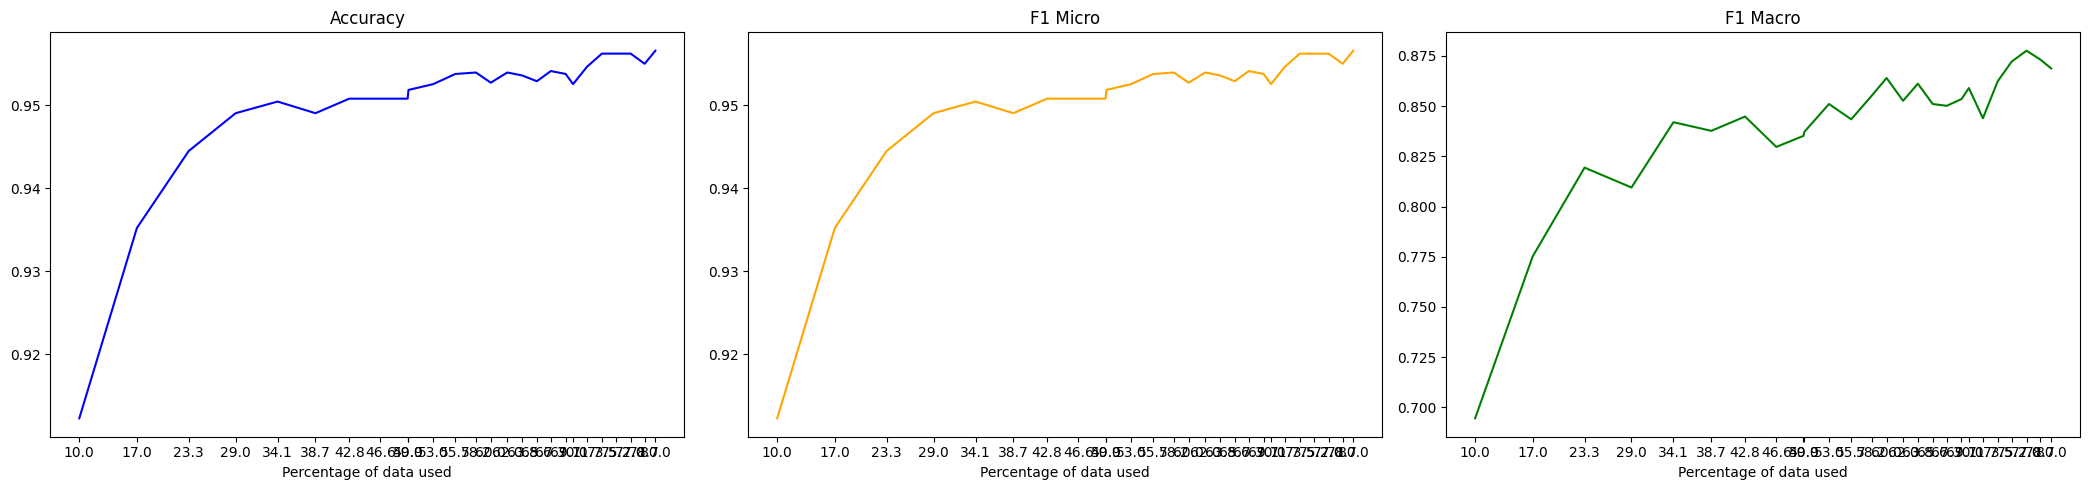

In [26]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)